In [2]:
from functools import partial

import jax
import jax.numpy as np
import flax.linen as nn
import optax
import diffrax as dfx

from sklearn import datasets, preprocessing

import matplotlib.pyplot as plt
from tqdm import trange

## The dataset

We'll use two moons to keep things simple.

(-2.0, 2.0)

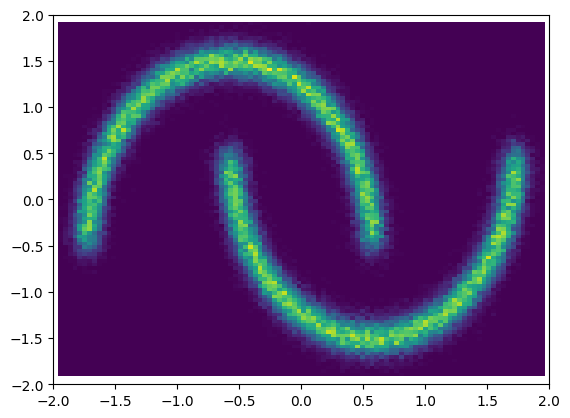

In [3]:
n_samples = 100_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

## Representing the stochastic process 

Represent the stochastic (noise-corruption, forward) process as the solution to an SDE,
$$\mathrm dx = f(x, t)\mathrm dt + g(t)\mathrm dw$$ 
where $f: \mathbb R^d \rightarrow \mathbb R^d$ is the (deterministic) drift coefficient and $g(t): \mathbb R \rightarrow \mathbb R$ is the diffusion coefficient. $w$ is Brownian motion (Weiner process) with $\mathrm dw$ representing infinitesimal white noise.

The solution to this SDE is a a continuous collection of random variables $\{x(t)\}_{t\in[0, T]}$. $p_t(x)$ is the marginal distribution of $x(t)$; $x\sim p_0(x)$ is the data distribution, and we take $p_T(x)$ to be close to a prior distribution $\pi(x)$ (typically a standard Gaussian) for some sufficiently large $T$.

The choice of SDE dictates the form of the the noise-corruption process; $d\mathrm x = e^t \mathrm dt$ would correspond to a zero-mean, exponentially-growing variance perturbation.

The SDE has a corresponding reverse-time SDE,
$$\mathrm dx = [f(x,t) - g^2(t)\nabla_x \log p_t(x)]\mathrm d t + g(t)\mathrm dw$$
so that after estimating the score, we can solve this reverse SDE and and arrive at a sample from the data distribution. Note that $\mathrm dt$ here is negative (reverse) time as we go from $T$ to $0$.

If we choose the SDE to be 
$$d\mathrm x = \sigma^t \mathrm dt.$$
In this case, the distribution of the corrupted data $x(t)$ given a sample $x(0)$ is
$$p(x(t)\mid x(0)) = \mathcal N(x(t); x(0), \frac{1}{2 \log \sigma}\left(\sigma^{2 t}-1\right) \mathbb{I})$$
where we get the variance by integrating $\int_{0}^{t}\mathrm d t' \sigma^{2t'}$.

Score model $s_\theta$ is trained using denoising objective:
$$\arg \min _\theta \mathbb{E}_{t \sim \mathcal U[0, 1]} \mathbb{E}_{x(0) \sim p_0(x)} \mathbb{E}_{x(t)\sim p_t(x(t) \mid x(0)) } \lambda(t)\left\|s_\theta(t, x(t))-\nabla_x \log p(x(t) \mid x(0))\right\|_2^2$$
where for an affine transition probability we can get this analytically, noting
$$s_\theta(x(t), t) - \nabla_x(t)\log p_t(x(t)\mid x(0)) = s_\theta(x(t), t) + \frac{x(t) - \mu}{\sigma^2} = s_\theta(x(t), t) + \epsilon / \sigma $$
where $\mu$ and $\sigma$ are the mean and standard deviation of the transition probability $p_t(x(t) \mid x(0))$ as calculated above.

In [4]:
sigma = 5.

def weight(t):
    return 0.5 / np.log(sigma) * (sigma ** (2 * t) - 1)

@partial(jax.jit, static_argnums=(3,))
def loss_fn(params, x, t, score, key):

    mu = x
    std = np.sqrt(0.5 / np.log(sigma) * (sigma ** (2 * t) - 1))

    eps = jax.random.normal(key, shape=x.shape)
    y = mu + std * eps

    pred = score.apply(params, np.concatenate([t, y], -1))

    loss = weight(t) * np.mean((pred * std + eps) ** 2)
    return loss.mean()

In [5]:
class MLP(nn.Module):
    """ A simple MLP in Flax. This is the score function.
    """
    hidden_dim: int = 32
    out_dim: int = 2
    n_layers: int = 2

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

Data-corruption is modeled by a variance-preserving SDE:
$$\mathrm dx(t) = -\frac{1}{2}\beta(t)x(t)\mathrm dt + \sqrt{\beta(t)}\mathrm d w(t)$$
for $t\in[0, 1]$. The mean and variance of this VP-SDE are given in terms of the integral of beta (`int_beta` here); see Eq. (29) of [Song et al (2020)](https://arxiv.org/abs/2011.13456) for details.

In [6]:
def int_beta(t):
    return t

def weight(t):
    return 1 - np.exp(-int_beta(t))

@partial(jax.jit, static_argnums=(3,4,))
def loss_fn(params, x, t, int_beta, score, key):
    mu = x * np.exp(-0.5 * int_beta(t))
    sigma = np.sqrt(1 - np.exp(-int_beta(t)))
    eps = jax.random.normal(key, shape=x.shape)
    y = mu + sigma * eps

    pred = score.apply(params, np.concatenate([y, t], -1))
    loss = weight(t) * np.mean((pred + eps / sigma) ** 2)
    return loss.mean()

In [7]:
key = jax.random.PRNGKey(0)
t = np.ones((x.shape[0], 1))

score = MLP(hidden_dim=128, out_dim=2, n_layers=5)
params = score.init(key, np.concatenate([x, t], axis=1))

## Training

In [8]:
opt = optax.adamw(learning_rate=3e-4, weight_decay=1e-4)
opt_state = opt.init(params)

In [9]:
n_steps = 10_000
n_batch = 128
T = 1.

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]
        t_batch = jax.random.uniform(key, shape=(x_batch.shape[0], 1), minval=0., maxval=T)

        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch, t_batch, int_beta, score, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)


100%|██████████| 10000/10000 [03:35<00:00, 46.31it/s, val=4.0427556]


## Sampling

### Sampling via solving the (reverse-time) probability-flow ODE

In [10]:
def single_sample_fn(model, params, data_shape, dt0, t1, key):
    def drift(t, y, args):
        t = np.atleast_1d(t)
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))  # Get beta via autodiff
        return -0.5 * beta * (y + model.apply(params, np.concatenate([y, t], -1)))

    term = dfx.ODETerm(drift)
    solver = dfx.Euler()
    t0 = 0
    y1 = jax.random.normal(key, data_shape)
    # Reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

In [11]:
dt = 0.01

single_sample_fn(score, params, (2,), dt, T, key)

Array([-0.12018913,  1.3058068 ], dtype=float32, weak_type=True)

In [12]:
sample_fn = partial(single_sample_fn, score, params, (2,), dt, T)

n_samples = 100
sample_key = jax.random.split(key, n_samples ** 2)
x_sample = jax.vmap(sample_fn)(sample_key)


(-2.0, 2.0)

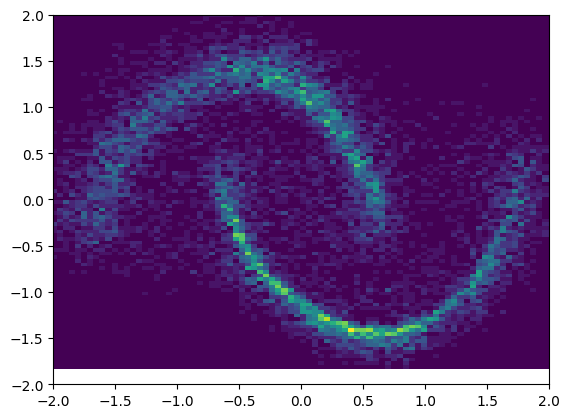

In [13]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

### Sampling via solving the reverse-time SDE

In [14]:

def single_sample_fn(model, params, data_shape, dt0, t1, key):
    def drift(t, y, args):
        t = np.atleast_1d(t)
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))  # Get beta via autodiff
        return -0.5 * beta * y - beta * model.apply(params, np.concatenate([y, t], -1))
    
    def diffusion(t, y, args):
        t = np.atleast_1d(t)
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))
        return np.sqrt(beta)

    t0 = 0

    bm = dfx.VirtualBrownianTree(t0, t1, tol=1e-4, shape=(1,), key=key)

    key, subkey = jax.random.split(key)

    terms = dfx.MultiTerm(dfx.ODETerm(drift), dfx.ControlTerm(diffusion, bm))

    solver = dfx.Euler()

    y1 = jax.random.normal(key, data_shape)

    sol = dfx.diffeqsolve(terms, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

In [15]:
dt = 0.01

single_sample_fn(score, params, (2,), dt, T, key)

Array([ 1.3353326 , -0.96778256], dtype=float32, weak_type=True)

In [16]:
sample_fn = partial(single_sample_fn, score, params, (2,), dt, T)

n_samples = 100
sample_key = jax.random.split(key, n_samples ** 2)
x_sample = jax.vmap(sample_fn)(sample_key)

(-2.0, 2.0)

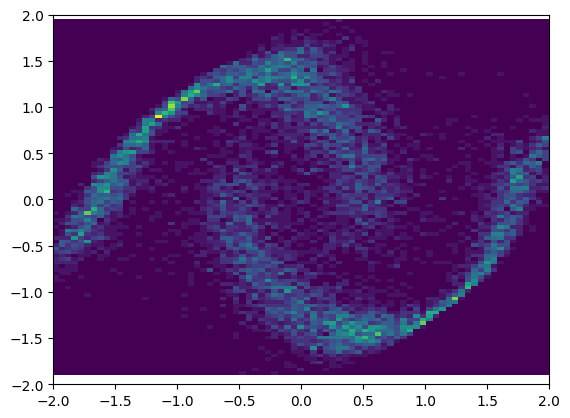

In [17]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

### Sampling via manual implementation of Euler

$$x_{t - \Delta t} = x_t - [f(x,t) - g(t)^2 s_\theta(x_t,t)]\Delta t + g(t)\sqrt{\Delta t} z_t$$

In [18]:
def single_sample_fn(model, params, dt0, t1, key):

    t = t1
    xT = jax.random.normal(key, (2,))

    for i in range(n_steps):
        
        key, subkey = jax.random.split(key)

        t = np.atleast_1d(t)
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))

        a = -0.5 * beta * xT - beta * model.apply(params, np.concatenate([xT, t], -1))
        b = np.sqrt(beta)

        xT = xT - a * dt0 + b * np.sqrt(dt0) * jax.random.normal(key, xT.shape)
        t -= dt0

    return xT

n_steps = 100
dt = T / n_steps

key = jax.random.PRNGKey(42)

single_sample_fn(score, params, dt, T, key)

Array([-1.4672592,  0.75955  ], dtype=float32)

In [19]:
sample_fn = partial(single_sample_fn, score, params, dt, T)

n_samples = 100
sample_key = jax.random.split(key, n_samples ** 2)

x_sample = jax.vmap(sample_fn)(sample_key)

(-2.0, 2.0)

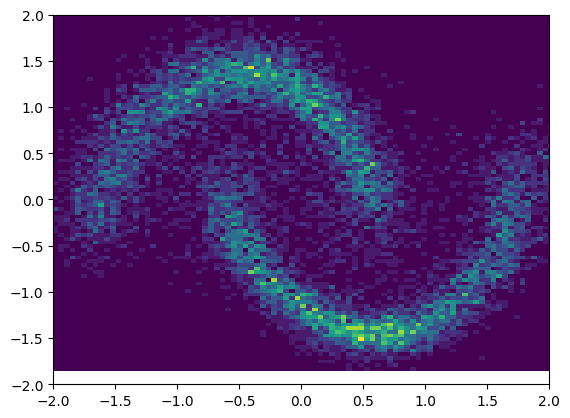

In [20]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

- Likelihood evaluation with Hutchinson estimator
- Likelihood-based training; connection to DDPM and reparameterization etc
- Understand contributions of different papers